In [19]:
"""
Name: Ciaran Cooney
Date: 12/01/2019
Description: Notebook for plotting a confusion matrix for single subjects.
"""

import torch
from utils import load_subject_eeg, eeg_to_3d, balanced_subsample, data_wrangler
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.torch_ext.util import np_to_var, var_to_np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from braindecode.experiments.monitors import compute_pred_labels_from_trial_preds

labels_w = ['Arriba', 'Abajo', 'Adelante', 'Atrás', 'Derecha', 'Izquierda']
labels_v = ['/a/', '/e/', '/i/', '/o/', '/u/']
labels_c = ['/a/', '/e/', '/i/', '/o/', '/u/', 'Arriba', 'Abajo', 'Adelante', 'Atrás', 'Derecha', 'Izquierda']

In [3]:
"""
function for predicting labels from pretrained model.
"""
from braindecode.datautil.iterators import BalancedBatchSizeIterator

def predict(model, X_test, batch_size, threshold_for_binary_case=None):
    with th.no_grad():
        for b_X, _ in iterator.get_batches(SignalAndTarget(X_test, X_test), False):
            b_X_var = np_to_var(b_X)
            all_preds.append(var_to_np(model(b_X_var)))

        pred_labels = compute_pred_labels_from_trial_preds(
                    all_preds, threshold_for_binary_case)
    return pred_labels

In [13]:
"""
Confusion matrix plotting using Seaborn. Matplotlib below.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, filename, normalize = True, figsize = (5,5), fontsize=16):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = (confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    fmt = '.2f' if normalize else 'd'
    #####set heatmap customization#####
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap='GnBu', linewidths=.5, cbar=False, annot_kws={"size": 16})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=16, fontname='sans-serif')
    plt.xlabel('Predicted label', fontsize=16, fontname='sans-serif')
    
    if filename != None:
        fig.savefig(filename + '.png', bbox_inches='tight') #store image as .png
    
    return fig

In [11]:
"""
Alternative confusion matrix plotting function.
"""

import itertools

def plot_confusion_matrix(cm, classes, filename,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Code for confusion matrix extracted from here:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig = None
    print(cm)
    fig = plt.figure(1, figsize=(6.5, 3))
    #ax = plt.add_subplot(111)
    plt.tick_params(labelsize='small')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label', fontsize='medium', fontname='sans-serif')
    plt.xlabel('Predicted label', fontsize='medium', fontname='sans-serif')
    
    if filename != None:
        fig.savefig(filename + '.png', bbox_inches='tight')
    
    return figure


In [26]:
#####Run before each new confusion matrix is to be plotted#####
stats = {'precision': [],
             'recall': [],
             'f-score': []}
y_true_all = np.array([])
y_pred_all = np.array([])

In [31]:
"""
Run to make predictions of a pretrained model, collects relevant
statistics and print a confusion matrix.
"""

iterator = BalancedBatchSizeIterator(batch_size=64)
model_type = 'shallow'
data_type = 'vowels'
subject_id = '02'
data, labels = data_wrangler(data_type, subject_id)
data, labels = balanced_subsample(data, labels)
if data_type == 'words' or 'all_classes':
    data = data[:,:,768:1280]
elif data_type == 'vowels':
    data = data[:,:,512:1024]
num_folds = 4
data_holder, labels_holder = [],[]
data, _, labels, _ = train_test_split(data, labels, test_size=0, random_state=42) #shuffle the data/labels

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=10)

test_data = []
y_true = np.array([])

for inner_ind, outer_index in skf.split(data, labels):
    inner_fold, outer_fold     = data[inner_ind], data[outer_index]
    inner_labels, outer_labels = labels[inner_ind], labels[outer_index]
    outer_fold = outer_fold.reshape((outer_fold.shape[0],6,512,1))
    _, X_test, _, y_test = train_test_split(outer_fold, outer_labels, test_size=0.5, random_state=42, stratify=outer_labels)
    test_data.append(X_test)
    y_true = np.concatenate((y_true, y_test))

models = [0,1,2,3]
y_pred = np.array([])
for model_num in models:
    all_preds = []
    model = torch.load(f"C:/Users/cfcoo/OneDrive - Ulster University/Study_2/results/nested_results/{model_type}_{data_type}/S{subject_id}/"
f"{data_type}_{model_type}model_nc_{model_num+1}.pt", map_location='cpu')

    X_test = test_data[model_num]
    prediction = predict(model, X_test, 64)
    y_pred = np.concatenate((y_pred, prediction))
accuracy = accuracy_score(y_true,y_pred)
print(accuracy)
precision, recall, f_score,_ = precision_recall_fscore_support(y_true,y_pred)
stats['precision'].append(np.mean(precision))
stats['recall'].append(np.mean(recall))
stats['f-score'].append(np.mean(f_score))

# index = ['stats']
# df = pd.DataFrame(stats, index=index)
# print(df.head())

y_true_all = np.concatenate((y_true_all, y_true))
y_pred_all = np.concatenate((y_pred_all, y_pred))

Not on PC! Attempting to load from laptop.


C:\Anaconda\lib\site-packages\torch\serialization.py:425: SourceChangeWarning: source code of class 'braindecode.torch_ext.modules.Expression' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.25892857142857145


Normalized confusion matrix


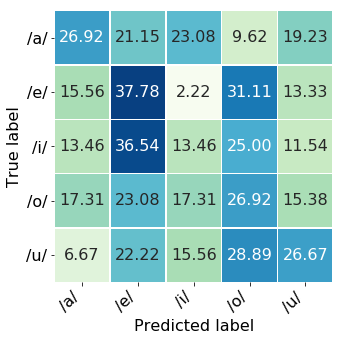

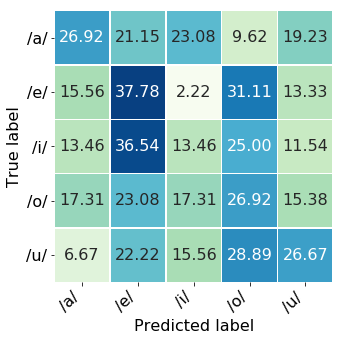

In [32]:
cm = confusion_matrix(y_true_all, y_pred_all)
print_confusion_matrix(cm, labels_v, filename=None)